# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.82KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

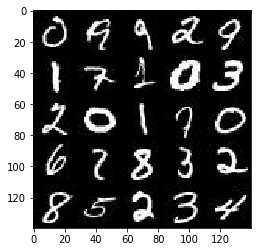

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

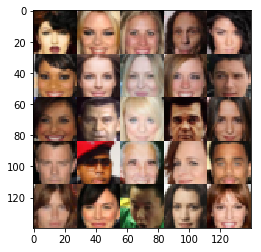

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 0.2338... Generator Loss: 2.0060
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 7.7926
Epoch 1/2... Discriminator Loss: 1.5497... Generator Loss: 4.7278
Epoch 1/2... Discriminator Loss: 0.5757... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 1.9128... Generator Loss: 0.2372
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.3318
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.1399
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.2329
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 2.2269


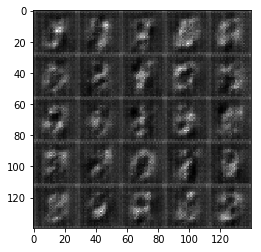

Epoch 1/2... Discriminator Loss: 1.5994... Generator Loss: 4.0381
Epoch 1/2... Discriminator Loss: 0.4345... Generator Loss: 1.7685
Epoch 1/2... Discriminator Loss: 0.3941... Generator Loss: 2.0427
Epoch 1/2... Discriminator Loss: 0.4437... Generator Loss: 1.3284
Epoch 1/2... Discriminator Loss: 0.2911... Generator Loss: 2.2338
Epoch 1/2... Discriminator Loss: 0.2236... Generator Loss: 2.3622
Epoch 1/2... Discriminator Loss: 0.2117... Generator Loss: 2.4250
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 0.4354... Generator Loss: 3.1446
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 8.6037


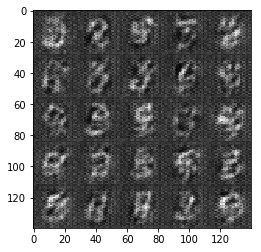

Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.5244
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 2.3692
Epoch 1/2... Discriminator Loss: 0.6101... Generator Loss: 2.9569
Epoch 1/2... Discriminator Loss: 0.3121... Generator Loss: 2.4669
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 0.3480... Generator Loss: 1.9645
Epoch 1/2... Discriminator Loss: 0.4190... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 2.2232... Generator Loss: 0.1629
Epoch 1/2... Discriminator Loss: 0.4705... Generator Loss: 1.6576
Epoch 1/2... Discriminator Loss: 0.2724... Generator Loss: 2.2367


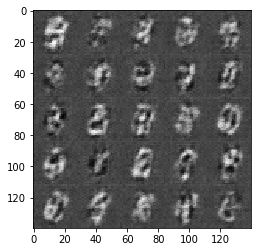

Epoch 1/2... Discriminator Loss: 0.3516... Generator Loss: 3.0532
Epoch 1/2... Discriminator Loss: 0.2010... Generator Loss: 2.3424
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 2.6588
Epoch 1/2... Discriminator Loss: 0.2720... Generator Loss: 2.3327
Epoch 1/2... Discriminator Loss: 0.2078... Generator Loss: 2.3070
Epoch 1/2... Discriminator Loss: 0.1898... Generator Loss: 2.6259
Epoch 1/2... Discriminator Loss: 0.2781... Generator Loss: 3.1770
Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 2.3708
Epoch 1/2... Discriminator Loss: 0.2118... Generator Loss: 2.7409
Epoch 1/2... Discriminator Loss: 0.1662... Generator Loss: 2.4894


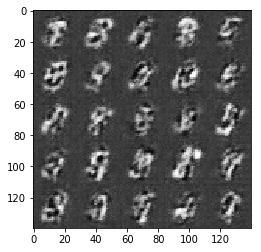

Epoch 1/2... Discriminator Loss: 0.1351... Generator Loss: 3.1168
Epoch 1/2... Discriminator Loss: 0.1402... Generator Loss: 2.7665
Epoch 1/2... Discriminator Loss: 2.0094... Generator Loss: 0.1940
Epoch 1/2... Discriminator Loss: 0.2675... Generator Loss: 1.9398
Epoch 1/2... Discriminator Loss: 0.2543... Generator Loss: 2.1031
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 2.3768
Epoch 1/2... Discriminator Loss: 0.1577... Generator Loss: 2.8866
Epoch 1/2... Discriminator Loss: 0.1518... Generator Loss: 2.7423
Epoch 1/2... Discriminator Loss: 0.2217... Generator Loss: 1.9887
Epoch 1/2... Discriminator Loss: 0.2478... Generator Loss: 3.6770


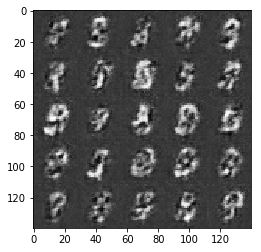

Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.1474... Generator Loss: 2.6973
Epoch 1/2... Discriminator Loss: 0.1193... Generator Loss: 3.0877
Epoch 1/2... Discriminator Loss: 6.5426... Generator Loss: 10.6507
Epoch 1/2... Discriminator Loss: 0.3351... Generator Loss: 2.1303
Epoch 1/2... Discriminator Loss: 0.3380... Generator Loss: 1.7165
Epoch 1/2... Discriminator Loss: 0.3452... Generator Loss: 1.6187
Epoch 1/2... Discriminator Loss: 0.2398... Generator Loss: 2.1643
Epoch 1/2... Discriminator Loss: 0.2938... Generator Loss: 1.7306
Epoch 1/2... Discriminator Loss: 0.1923... Generator Loss: 2.2456


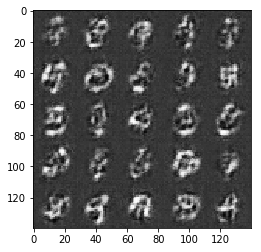

Epoch 1/2... Discriminator Loss: 0.1552... Generator Loss: 2.5524
Epoch 1/2... Discriminator Loss: 0.1707... Generator Loss: 2.3725
Epoch 1/2... Discriminator Loss: 0.1345... Generator Loss: 2.7494
Epoch 1/2... Discriminator Loss: 0.1427... Generator Loss: 2.5706
Epoch 1/2... Discriminator Loss: 0.1087... Generator Loss: 3.1264
Epoch 1/2... Discriminator Loss: 0.1662... Generator Loss: 4.0132
Epoch 1/2... Discriminator Loss: 0.0664... Generator Loss: 3.5538
Epoch 1/2... Discriminator Loss: 0.1933... Generator Loss: 2.0923
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 1.4976
Epoch 1/2... Discriminator Loss: 0.1388... Generator Loss: 2.6661


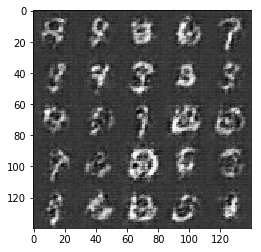

Epoch 1/2... Discriminator Loss: 0.1747... Generator Loss: 2.3705
Epoch 1/2... Discriminator Loss: 0.1539... Generator Loss: 2.6104
Epoch 1/2... Discriminator Loss: 0.1322... Generator Loss: 2.6960
Epoch 1/2... Discriminator Loss: 0.1120... Generator Loss: 3.0804
Epoch 1/2... Discriminator Loss: 0.1163... Generator Loss: 2.8208
Epoch 1/2... Discriminator Loss: 0.1532... Generator Loss: 2.4544
Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 3.0167
Epoch 1/2... Discriminator Loss: 0.1085... Generator Loss: 2.8095
Epoch 1/2... Discriminator Loss: 0.0905... Generator Loss: 3.0590
Epoch 1/2... Discriminator Loss: 0.0863... Generator Loss: 3.1878


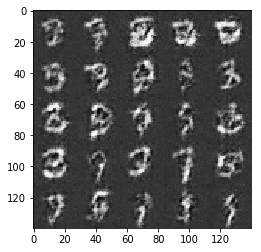

Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.6413
Epoch 1/2... Discriminator Loss: 0.0677... Generator Loss: 3.6112
Epoch 1/2... Discriminator Loss: 0.0851... Generator Loss: 2.9943
Epoch 1/2... Discriminator Loss: 5.5330... Generator Loss: 0.0333
Epoch 1/2... Discriminator Loss: 0.2259... Generator Loss: 2.0992
Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 2.9963
Epoch 1/2... Discriminator Loss: 0.1359... Generator Loss: 2.7983
Epoch 1/2... Discriminator Loss: 0.1148... Generator Loss: 2.7914
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 2.7498
Epoch 1/2... Discriminator Loss: 0.0819... Generator Loss: 3.2297


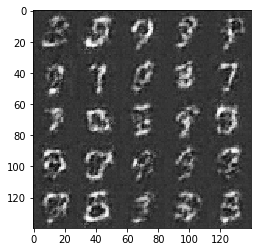

Epoch 1/2... Discriminator Loss: 0.1397... Generator Loss: 2.4631
Epoch 1/2... Discriminator Loss: 0.0784... Generator Loss: 3.1907
Epoch 1/2... Discriminator Loss: 0.1001... Generator Loss: 2.7812
Epoch 2/2... Discriminator Loss: 0.0733... Generator Loss: 3.4217
Epoch 2/2... Discriminator Loss: 0.0976... Generator Loss: 2.9351
Epoch 2/2... Discriminator Loss: 0.0643... Generator Loss: 3.3274
Epoch 2/2... Discriminator Loss: 0.0762... Generator Loss: 3.1322
Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 3.2343
Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 3.6608
Epoch 2/2... Discriminator Loss: 0.0839... Generator Loss: 3.1833


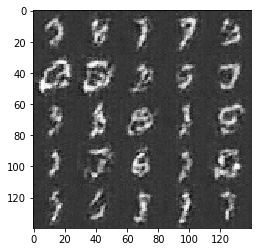

Epoch 2/2... Discriminator Loss: 0.0516... Generator Loss: 3.8438
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 3.8487
Epoch 2/2... Discriminator Loss: 0.0531... Generator Loss: 3.6569
Epoch 2/2... Discriminator Loss: 0.0503... Generator Loss: 3.9522
Epoch 2/2... Discriminator Loss: 0.0442... Generator Loss: 4.1230
Epoch 2/2... Discriminator Loss: 0.0547... Generator Loss: 3.6859
Epoch 2/2... Discriminator Loss: 0.0624... Generator Loss: 3.2864
Epoch 2/2... Discriminator Loss: 0.0441... Generator Loss: 3.9330
Epoch 2/2... Discriminator Loss: 0.0549... Generator Loss: 3.6532
Epoch 2/2... Discriminator Loss: 0.0492... Generator Loss: 3.7615


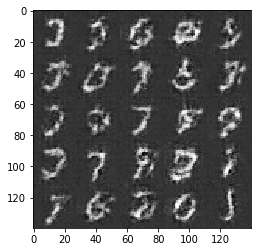

Epoch 2/2... Discriminator Loss: 0.0441... Generator Loss: 3.8341
Epoch 2/2... Discriminator Loss: 0.0669... Generator Loss: 3.4363
Epoch 2/2... Discriminator Loss: 0.0531... Generator Loss: 3.5703
Epoch 2/2... Discriminator Loss: 0.0386... Generator Loss: 4.1271
Epoch 2/2... Discriminator Loss: 0.0396... Generator Loss: 4.2171
Epoch 2/2... Discriminator Loss: 0.0427... Generator Loss: 3.8490
Epoch 2/2... Discriminator Loss: 0.0468... Generator Loss: 4.5578
Epoch 2/2... Discriminator Loss: 0.0465... Generator Loss: 3.7078
Epoch 2/2... Discriminator Loss: 18.2771... Generator Loss: 19.2824
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.5220


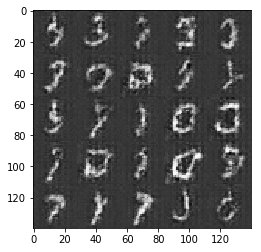

Epoch 2/2... Discriminator Loss: 0.2405... Generator Loss: 2.3776
Epoch 2/2... Discriminator Loss: 0.1703... Generator Loss: 2.5138
Epoch 2/2... Discriminator Loss: 0.1193... Generator Loss: 2.8387
Epoch 2/2... Discriminator Loss: 0.1129... Generator Loss: 3.0508
Epoch 2/2... Discriminator Loss: 0.1204... Generator Loss: 2.7608
Epoch 2/2... Discriminator Loss: 0.1223... Generator Loss: 2.6810
Epoch 2/2... Discriminator Loss: 0.1579... Generator Loss: 2.3589
Epoch 2/2... Discriminator Loss: 0.0836... Generator Loss: 3.4826
Epoch 2/2... Discriminator Loss: 0.0842... Generator Loss: 3.1398
Epoch 2/2... Discriminator Loss: 0.1164... Generator Loss: 2.6700


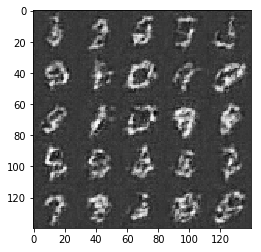

Epoch 2/2... Discriminator Loss: 0.1190... Generator Loss: 2.6921
Epoch 2/2... Discriminator Loss: 0.1127... Generator Loss: 2.8731
Epoch 2/2... Discriminator Loss: 0.1042... Generator Loss: 2.8240
Epoch 2/2... Discriminator Loss: 0.0920... Generator Loss: 3.1400
Epoch 2/2... Discriminator Loss: 0.0994... Generator Loss: 2.8297
Epoch 2/2... Discriminator Loss: 0.1416... Generator Loss: 2.4586
Epoch 2/2... Discriminator Loss: 0.1259... Generator Loss: 2.5762
Epoch 2/2... Discriminator Loss: 0.0893... Generator Loss: 3.0652
Epoch 2/2... Discriminator Loss: 0.1176... Generator Loss: 2.6621
Epoch 2/2... Discriminator Loss: 0.1028... Generator Loss: 2.7208


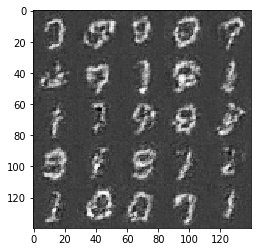

Epoch 2/2... Discriminator Loss: 0.0746... Generator Loss: 4.2075
Epoch 2/2... Discriminator Loss: 0.1624... Generator Loss: 2.4085
Epoch 2/2... Discriminator Loss: 0.0801... Generator Loss: 3.0546
Epoch 2/2... Discriminator Loss: 0.1212... Generator Loss: 2.6934
Epoch 2/2... Discriminator Loss: 0.2251... Generator Loss: 1.9708
Epoch 2/2... Discriminator Loss: 0.1073... Generator Loss: 2.7561
Epoch 2/2... Discriminator Loss: 0.1311... Generator Loss: 2.5830
Epoch 2/2... Discriminator Loss: 0.0924... Generator Loss: 3.0538
Epoch 2/2... Discriminator Loss: 0.0578... Generator Loss: 3.4366
Epoch 2/2... Discriminator Loss: 0.0910... Generator Loss: 3.0589


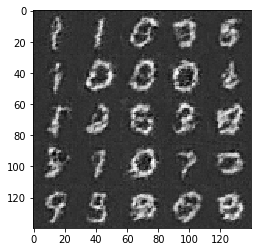

Epoch 2/2... Discriminator Loss: 9.8834... Generator Loss: 10.7979
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 1.4876
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 2.1035
Epoch 2/2... Discriminator Loss: 0.2419... Generator Loss: 2.0742
Epoch 2/2... Discriminator Loss: 0.1904... Generator Loss: 2.2651
Epoch 2/2... Discriminator Loss: 0.1689... Generator Loss: 2.4303
Epoch 2/2... Discriminator Loss: 0.1958... Generator Loss: 2.1616
Epoch 2/2... Discriminator Loss: 0.1260... Generator Loss: 2.7984
Epoch 2/2... Discriminator Loss: 0.1235... Generator Loss: 2.6592


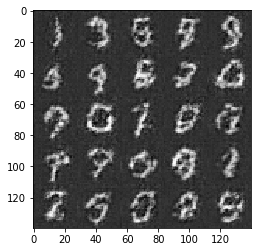

Epoch 2/2... Discriminator Loss: 0.1199... Generator Loss: 2.6493
Epoch 2/2... Discriminator Loss: 0.1284... Generator Loss: 2.6116
Epoch 2/2... Discriminator Loss: 0.1093... Generator Loss: 2.7158
Epoch 2/2... Discriminator Loss: 0.0822... Generator Loss: 2.9460
Epoch 2/2... Discriminator Loss: 0.0880... Generator Loss: 2.9367
Epoch 2/2... Discriminator Loss: 0.1042... Generator Loss: 2.8371
Epoch 2/2... Discriminator Loss: 0.0915... Generator Loss: 2.8244
Epoch 2/2... Discriminator Loss: 0.1190... Generator Loss: 2.5724
Epoch 2/2... Discriminator Loss: 0.0799... Generator Loss: 3.0479
Epoch 2/2... Discriminator Loss: 0.0889... Generator Loss: 2.8174


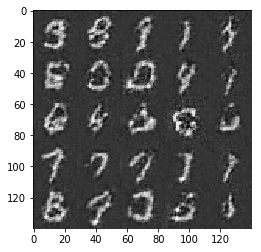

Epoch 2/2... Discriminator Loss: 0.0773... Generator Loss: 3.1201
Epoch 2/2... Discriminator Loss: 0.0652... Generator Loss: 3.2696
Epoch 2/2... Discriminator Loss: 2.9623... Generator Loss: 0.0865
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.9204
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 1.4030
Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.5481
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.1953


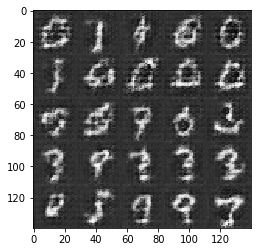

Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.1928
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 1.3398
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.5959
Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 4.0194
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 3.6168


In [59]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.6345
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 1.6335
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 2.0887
Epoch 1/1... Discriminator Loss: 0.2874... Generator Loss: 2.3867
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.1350
Epoch 1/1... Discriminator Loss: 0.3249... Generator Loss: 2.6184


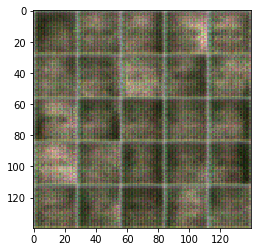

Epoch 1/1... Discriminator Loss: 0.3062... Generator Loss: 2.0677
Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 2.5581
Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 2.0865
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 2.1201
Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 2.3574
Epoch 1/1... Discriminator Loss: 0.2981... Generator Loss: 2.9891
Epoch 1/1... Discriminator Loss: 0.2475... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 2.4970
Epoch 1/1... Discriminator Loss: 2.4976... Generator Loss: 0.1653
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 1.7304


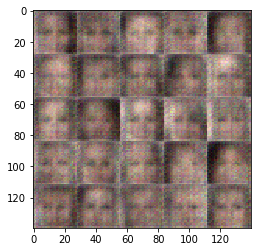

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.5341
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.6672


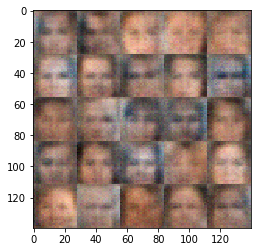

Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 2.1065
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.3458
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.4338
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 2.3055


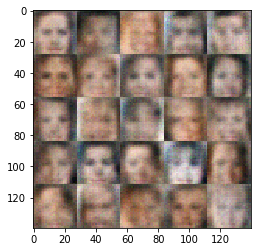

Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 2.2630
Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 2.7796
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 2.9149
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.8503
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 3.1283


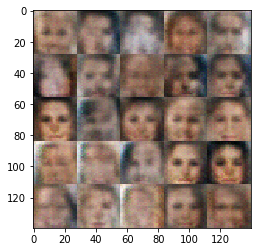

Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.2171... Generator Loss: 2.8178
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 1.8978
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 2.0806
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 2.0508
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 1.8390
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 1.6625


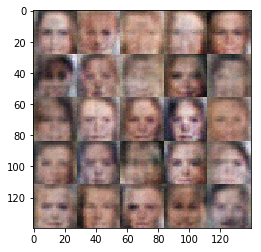

Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 2.0707
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 1.4276
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.0971
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 0.2885... Generator Loss: 2.2671
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 3.9294
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 3.7596
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.0021


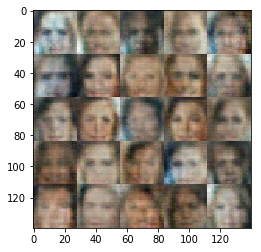

Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 1.9122
Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 2.9146
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 4.7794
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 2.7833
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 1.6099


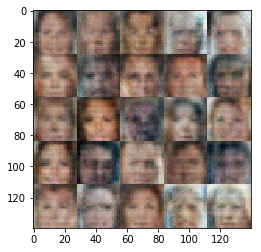

Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 1.8900
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 2.9592
Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 2.6938
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 4.7332
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.0811


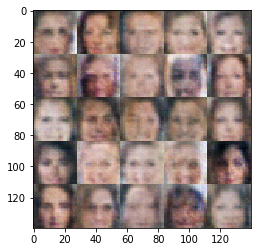

Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 2.9375
Epoch 1/1... Discriminator Loss: 0.1304... Generator Loss: 4.3625
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 9.0150
Epoch 1/1... Discriminator Loss: 0.2924... Generator Loss: 1.8067
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 8.5021
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 4.6414
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 9.8574
Epoch 1/1... Discriminator Loss: 0.2236... Generator Loss: 1.9900


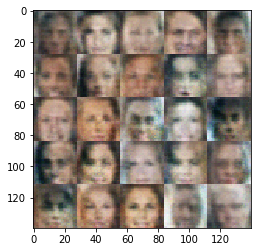

Epoch 1/1... Discriminator Loss: 0.0924... Generator Loss: 3.0780
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 2.3063
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 5.8717
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 6.2262
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 4.9473
Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 1.8880
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 5.3305
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 6.9443
Epoch 1/1... Discriminator Loss: 0.2744... Generator Loss: 10.0508


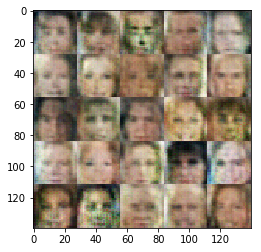

Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 0.1632... Generator Loss: 7.3399
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 2.3826
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 8.1219
Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 9.3427
Epoch 1/1... Discriminator Loss: 0.0764... Generator Loss: 7.3949
Epoch 1/1... Discriminator Loss: 0.0941... Generator Loss: 3.3268
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 7.6216
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 5.6788
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 0.8982


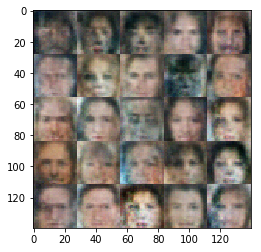

Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 5.6875
Epoch 1/1... Discriminator Loss: 0.0210... Generator Loss: 6.8329
Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 6.3135
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.5278
Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 7.7725
Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 7.8054
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 4.8445
Epoch 1/1... Discriminator Loss: 0.0691... Generator Loss: 6.1298
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 6.4598


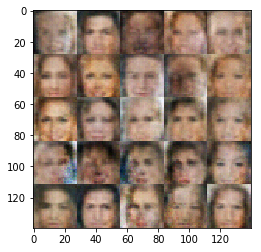

Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 2.9202
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.2317
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 2.9893
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 5.9934
Epoch 1/1... Discriminator Loss: 0.1708... Generator Loss: 2.8723
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 6.6875
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 3.8424
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 9.5313
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 2.7752
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 6.0722


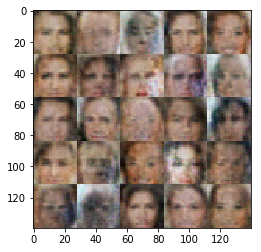

Epoch 1/1... Discriminator Loss: 0.1419... Generator Loss: 2.3756
Epoch 1/1... Discriminator Loss: 0.2463... Generator Loss: 8.5929
Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 5.0453
Epoch 1/1... Discriminator Loss: 0.1068... Generator Loss: 10.6580
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 6.3130
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 5.3145
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 10.1055
Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 6.2037
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 6.2882
Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 3.4138


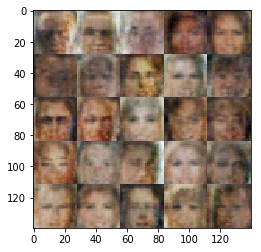

Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 7.8438
Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 8.2396
Epoch 1/1... Discriminator Loss: 0.0165... Generator Loss: 7.7024
Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 7.5254
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 0.0433... Generator Loss: 6.9746
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 2.9473
Epoch 1/1... Discriminator Loss: 0.0698... Generator Loss: 3.4253


In [62]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.